# this is the manuscript for ploting Figure 5 in the lake ice manuscript

In [1]:
import numpy as np # version '1.20.0'
import xarray as xr # version '0.16.2'
from tqdm import tqdm # version '4.43.0'
import matplotlib.pyplot as plt # version '3.3.2'
import matplotlib as mpl # version '3.3.2'
import cmocean # version '2.0'
import cartopy.crs as ccrs # version '0.18.0'
import cartopy.feature as cf # version '0.18.0'
import glob
import dask.array as da # version '2021.1.1'
import time
from numpy import nan
import seaborn as sns # version '0.11.0'
import pandas as pd # version 1.2.1'
import matplotlib.path as mpath

In [3]:
# setup the dask parallel computing
from dask.distributed import Client
client = Client(scheduler_file= '/.../scheduler.json') # the path to the scheduler file
client

Client Scheduler: tcp://203.247.189.224:43634 Dashboard: http://203.247.189.224:8787/status,Cluster Workers: 16 Cores: 576 Memory: 320.00 GB


# 1. define functions

## 1.1 define functions to read in nc files across all the ensemble members
The variables stored in the directories of individual ensemble members ,we use this function to read the data of all the ensemble members into one xarray dataset

In [8]:
def def_process_coords(exceptcv=[]):
    def process_coords(ds, except_coord_vars=exceptcv):
        coord_vars = []
        for v in np.array(ds.coords):
            if not v in except_coord_vars:
                coord_vars += [v]
        for v in np.array(ds.data_vars):
            if not v in except_coord_vars:
                coord_vars += [v]
        return ds.drop(coord_vars)
    return process_coords
#-----------------------------------------------------------------------------------------------------
def read_in(var, exceptcv, domain='lnd/', freq='day_1/', stream='h6', chunks=dict(time=365), ens_s=-20, ens_e=-10):
    ens_dir = "path for the home directory of the whole CESM-LE data"
    histens_names = [member.split('archive/')[1][:-1]
                     for member in sorted(glob.glob(ens_dir + "b.e21.BHIST*LE2*[!old][!tmp]/"))][10:]
    projens_names = [member.split('archive/')[1][:-1] for member in sorted(
        glob.glob(ens_dir + "b.e21.BSSP370*.f09_g17*[!old][!tmp]/"))][10:]
    hist_ncfiles = []
    proj_ncfiles = []
    for i in np.arange(ens_s, ens_e):
        hist_fnames = sorted(glob.glob(
            ens_dir + histens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        proj_fnames = sorted(glob.glob(
            ens_dir + projens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        hist_ncfiles.append(hist_fnames)
        proj_ncfiles.append(proj_fnames)
    ens_numbers = [members.split('LE2-')[1]
                   for members in histens_names][ens_s:ens_e]
    hist_ds = xr.open_mfdataset(hist_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    proj_ds = xr.open_mfdataset(proj_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    if freq == 'day_1/':
        hist_ds = hist_ds.isel(time=np.arange(1, hist_ds.time.shape[0]))
        proj_ds = proj_ds.isel(time=np.arange(1, proj_ds.time.shape[0]))
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'D')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'D')
    if freq == 'month_1/':
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'M')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'M')
    ens_ds = xr.concat((hist_ds, proj_ds), 'time')
    ens_ds = ens_ds.rename({'concat_dim': 'ensemble'})
    return ens_ds


## 1.2 define functions calculate linear trend along time dimension 

In [5]:
# this function refers code from https://gist.github.com/luke-gregor/4bb5c483b2d111e52413b260311fbe43
def xarray_trend(xarr,taxis = 'time', units = '\u2103'):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    x = np.arange(xarr[taxis][0],xarr[taxis][-1:] + 1,1)[:,None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    
    # preparing outputs
    out = xarr[:2].mean(taxis)
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = units + ' / ' + taxis
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

## 1.3 build a mask array transfer lonxlat grid into a sequential order 
please note, not all the grids has lake simulaiton, in the grids without lake simulation, the values are NaN, to reduce the running memory cost, we transfer lonxlat grid into a sequential order and delete those grids without lake simulation, thus improving the computing efficiency

In [7]:
mask_ds = xr.open_mfdataset('.../b.e21.BHISTcmip6.f09_g17.LE2-1231.001.clm2.h2.EFLX_LH_TOT.185001-185912.nc', # randomly read in one clm5 output file to extract information for the coordinates
                        combine = 'by_coords',
                          parallel=True)

In [9]:
ixy = mask_ds.land1d_ixy - 1
ixy['landunit'] = mask_ds.land1d_ityplunit
lake_ixy = ixy.sel(landunit = 5).astype(int).compute()
jxy = mask_ds.land1d_jxy - 1
jxy['landunit'] = mask_ds.land1d_ityplunit
lake_jxy = jxy.sel(landunit = 5).astype(int).compute()
## change lake_ixy lake_jxy coordinate to make it consistent with computation afterwards
lake_ixy['landunit'] = np.arange(lake_ixy.shape[0])
lake_jxy['landunit'] = np.arange(lake_jxy.shape[0])

In [10]:
landunit_idx = mask_ds.landunit
landunit_idx['landunit'] = mask_ds.land1d_ityplunit
lake_idx = landunit_idx.sel(landunit = 5).values

calculate the lake area and make mask to remove antarctic and greenland

In [12]:
pct_lake_ds = xr.open_dataset('.../surfdata_map/surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc')# the surface input data for CLM5
pct_lake = pct_lake_ds.PCT_LAKE / 100
pct_lake = pct_lake.rename({'lsmlat':'lat','lsmlon':'lon'})
pct_lake = pct_lake.where(pct_lake > 0)
pct_lake['lat'] = mask_ds.lat
pct_lake['lon'] = mask_ds.lon

landfrac  = pct_lake_ds.LANDFRAC_PFT
landfrac  = landfrac.rename({'lsmlat':'lat','lsmlon':'lon'})
landfrac['lat'] = mask_ds.lat
landfrac['lon'] = mask_ds.lon

cell_area = pct_lake_ds.AREA
cell_area = cell_area.rename({'lsmlat':'lat','lsmlon':'lon'})
cell_area['lat'] = mask_ds.lat
cell_area['lon'] = mask_ds.lon

In [13]:
## setup mask to remove ocean and ice sheet area
glacier_region = pct_lake_ds.GLACIER_REGION
glacier_region = glacier_region.rename(dict(lsmlat = 'lat', lsmlon = 'lon'))
glacier_region['lat'] = mask_ds.lat
glacier_region['lon'] = mask_ds.lon

landfrac = landfrac.where(glacier_region == 0,0)

pct_lake = pct_lake.where(landfrac > 0)

lake_area = cell_area * landfrac * pct_lake

In [14]:
lake_mask = (pct_lake_ds.PCT_LAKE > 0)
lake_mask = lake_mask.rename({'lsmlat':'lat','lsmlon':'lon'})
lake_mask['lat'] = mask_ds.lat
lake_mask['lon'] = mask_ds.lon
## remove lakes in antarctic and greenland
lake_mask = lake_mask.where(landfrac > 0,False)

In [15]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]

In [16]:
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

In [17]:
lake_ixy = lake_ixy.sel(landunit = lake_mask_lunit)
lake_jxy = lake_jxy.sel(landunit = lake_mask_lunit)
lake_idx = lake_idx[lake_mask_lunit]
lake_area_lunit = lake_area_lunit.sel(landunit = lake_mask_lunit)

In [18]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

# 2. Read in data and calculating the time of emergence for anthropogenic signal and no-analogue condition

## 2.1 Read in data CESM2-LE ice phenology data

In [20]:
# these data has been calculated in the calculation script
iceduration_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEDURATION_mod.nc', chunks = {'year':1, 'lat':64}).iceduration
iceon_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEON_mod.nc', chunks = {'year':1, 'lat':64}).iceon 
iceoff_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEOFF_mod.nc', chunks = {'year':1, 'lat':64}).iceoff
daily_ice_max = xr.open_mfdataset('/proj/lhuang/LENS/ICEMAX_mod.nc', chunks = {'year':1, 'lat':64}).icemax

In [22]:
iceon_mod_ensmean  = iceon_mod.mean('ensemble').compute()
iceoff_mod_ensmean = iceoff_mod.mean('ensemble').compute()
iceduration_mod_ensmean = iceduration_mod.mean('ensemble').compute()
icemax_mod_ensmean = daily_ice_max.mean('ensemble').compute()

In [23]:
iceduration_2010 = iceduration_mod[:,150:160,...].where(iceduration_mod[:,150:160,...] > 0 )
iceduration_2010_ann = iceduration_2010.count('year').sum('ensemble').compute()
iceduration_2010_ann_mask = (iceduration_2010_ann > (10 * iceduration_mod.shape[0] - 10))
iceduration_2010_int_mask = xr.ufuncs.logical_and(iceduration_2010_ann <= (10 * iceduration_mod.shape[0] - 10), iceduration_2010_ann > 0 )
iceduration_2100 = iceduration_mod[:,-10:,...].where(iceduration_mod[:,-10:,...] > 0 )
iceduration_2100_ann = iceduration_2100.count('year').sum('ensemble').compute()
iceduration_2100_int_mask  = xr.ufuncs.logical_and( (iceduration_2100_ann < (10 * iceduration_mod.shape[0] - 10)), iceduration_2010_ann > 0)
iceduration_2100_int_mask  = xr.ufuncs.logical_and(iceduration_2100_int_mask,  ~iceduration_2010_int_mask )

In [24]:
hatch_lats_2010 = []
hatch_lons_2010 = []
for i in np.arange(iceduration_2010_int_mask.shape[1]):
    for j in np.arange(iceduration_2010_int_mask.shape[0]):
        if iceduration_2010_int_mask[j,i]:
            hatch_lats_2010.append(iceduration_2010_int_mask.lat.values[j])
            hatch_lons_2010.append(iceduration_2010_int_mask.lon.values[i])
hatch_lats_2010 = np.asarray(hatch_lats_2010)
hatch_lons_2010 = np.asarray(hatch_lons_2010)
hatch_lats_2100 = []
hatch_lons_2100 = []
for i in np.arange(iceduration_2100_int_mask.shape[1]):
    for j in np.arange(iceduration_2100_int_mask.shape[0]):
        if iceduration_2100_int_mask[j,i]:
            hatch_lats_2100.append(iceduration_2100_int_mask.lat.values[j])
            hatch_lons_2100.append(iceduration_2100_int_mask.lon.values[i])
hatch_lats_2100 = np.asarray(hatch_lats_2100)
hatch_lons_2100 = np.asarray(hatch_lons_2100)

## 2.2 calculation

Calculate the time window of shifting process from natural habitat to a new habitat based on ice duration

In [25]:
## calculate the natural variability
pi_std = iceduration_mod.sel(year = slice(1850,1950)).std(('year','ensemble')).compute()
pi_mean= iceduration_mod.sel(year = slice(1850,1950)).mean(('year','ensemble')).compute()
comfort_line = pi_mean - pi_std * 2
## comfort_line cannot be negative
comfort_line = comfort_line.where(comfort_line >0, 0)

In [26]:
mask_window_start = xr.where( (iceduration_mod_ensmean.sel(year = slice(1951,2100)) - 2 * iceduration_mod.sel(year = slice(1951,2100)).std('ensemble') ) <= comfort_line, 1, 0)
mask_window_end   = xr.where( (iceduration_mod_ensmean.sel(year = slice(1951,2100)) + 2 * iceduration_mod.sel(year = slice(1951,2100)).std('ensemble') ) <= comfort_line, 1, 0)
mask_window_start = mask_window_start.where(iceduration_2010_ann > 0 ).compute()
mask_window_end = mask_window_end.where(iceduration_2010_ann > 0 ).compute()

In [28]:
from xclim.indices.run_length import rle_1d
def consecutive_idx(x):
    vals0, lengths0, indx0 =  rle_1d(x)
    lengths0_masked = lengths0[np.where(vals0 == 1)[0]]
    indx0_masked    = indx0[np.where(vals0 == 1)[0]]
    if (lengths0_masked.shape[0] > 0):
        lengths0_masked_masked = lengths0_masked[np.where(lengths0_masked >=5)[0]]
        indx0_masked_masked    = indx0_masked[np.where(lengths0_masked >=5)[0]]
        if (lengths0_masked_masked.shape[0] > 0):
            return np.arange(1951,2100)[indx0_masked_masked[0]]
        else:
            return 2100
    else:
        return 2100
#
def adap_years(mask_array_start,mask_array_end):
    if np.isnan(mask_array_start).any():
        return nan
    else:
        start = consecutive_idx(mask_array_start)
        end   = consecutive_idx(mask_array_end)
        if end == 2100:
            adap_window = 150#149
        else:
            adap_window = end - start + 1
        return adap_window
#
def signal_emerge(mask_array_start,mask_array_end):
    if np.isnan(mask_array_start).any():
        return nan
    else:
        start = consecutive_idx(mask_array_start)
        return start
#
def signal_termin(mask_array_start,mask_array_end):
    if np.isnan(mask_array_end).any():
        return nan
    else:
        end = consecutive_idx(mask_array_end)
        return end

In [29]:
# iceduraiton_sig_emerge is the time of emergence of anthropogenic signal,
# iceduration_sig_termin is the time of emergence of no-analogue conditions
iceduration_sig_emerge = xr.apply_ufunc(signal_emerge,
                                     mask_window_start,
                                     mask_window_end,
                                     input_core_dims=[['year'],['year']],
                                     vectorize= True)
iceduration_sig_termin = xr.apply_ufunc(signal_termin,
                                     mask_window_start,
                                     mask_window_end,
                                     input_core_dims=[['year'],['year']],
                                     vectorize= True)
iceduration_adap_window = xr.apply_ufunc(adap_years,
                                     mask_window_start,
                                     mask_window_end,
                                     input_core_dims=[['year'],['year']],
                                     vectorize= True)

# 3. plot the Figure 5

In [30]:
'''
update universal settings for fonts
'''
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'pdf.fonttype': 42,
    'font.size':5,
    'axes.linewidth':0.3,
    'xtick.major.width':0.5,
    'xtick.minor.width':0.3,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3})

## 3.1 define the functions to plot

In [112]:
from matplotlib.patches import Patch
def line_span_hist_plot(input_data = iceduration_mod, input_data_std = pi_std,
                        time_emerge = iceduration_sig_emerge, time_termin = iceduration_sig_termin,
                        ilat = 146, ilon = 219,
                        left = 0, width = 0.5,width_h = 0.2,
                        bottom = 0, height = 0.5,
                        mother_fig = None):

    input_data = input_data[:,:,ilat,ilon].compute()
    bottom_h = left_h = left + width
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, width_h,height]

    ax = mother_fig.add_axes(rect_histy,
             frame_on = False)
    sns.distplot(input_data[:,0:100],
                vertical = True,
                ax = ax,
                color = 'orange',
                norm_hist = True,
                hist_kws={'linewidth':0},
                kde_kws = {'linewidth':0.8})
    ax.set_ylim(-3,140)
    ax.set_xlim(0,0.05)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axhline(input_data[:,0:100].mean() + input_data_std[ilat,ilon] * 2,
               xmin = 0,
               xmax = 0.2,
               c = 'green',
               ls = '-.' ,
              lw = 0.8)
    ax.axhline(input_data[:,0:100].mean() - input_data_std[ilat,ilon] * 2,
               xmin = 0,
               xmax = 0.2,
               c = 'green',
               ls = '-.' ,
              lw = 0.8)


    axs = fig.add_axes(rect_scatter)
    axs.fill_betweenx(y = np.arange(-3,142),
                      x1 = time_emerge[ilat,ilon],
                      x2 = time_termin[ilat,ilon],
                      color = 'Gray',
                      alpha = 0.4,
                      zorder = 1)
    input_data[:,:].mean('ensemble').plot(ax = axs,
                                              color = 'red',
                                              lw = 0.8,
                                              zorder = 10)
    y_mean = input_data.mean('ensemble')
    y_std  = input_data.std('ensemble')
    axs.fill_between(x = y_mean.year,
                    y1 = y_mean - 2* y_std,
                     y2 = y_mean + 2 * y_std,
                    color = 'Blue',
                    alpha = 0.2,
                    label = '2$\sigma$')

    for i in np.arange(input_data.shape[0]):
        axs.scatter(input_data.year,
                    input_data[i,:],
                    c = 'royalblue',
                    alpha = 0.4,
                    s = 0.8,
                    edgecolor = 'none',
                    zorder = 3)
    axs.axhline(input_data[:,0:100].mean() + input_data_std[ilat,ilon] * 2,
               c = 'green',
               ls = '-.'  ,
              lw = 0.8)
    axs.axhline(input_data[:,0:100].mean() - input_data_std[ilat,ilon] * 2,
               c = 'green',
               ls = '-.' ,
              lw = 0.8)

    axs.set_ylim(-3,140)
    axs.set_xlim(1850,2100)
    axs.set_ylabel('Ice duration (day)')
    axs.set_xlabel('Year')
    axs.set_title('')


    axs.text(1855,
             32,
             '{0:.1f} $\degree$N \n {1:.1f} $\degree$W'.format(input_data.lat.values, 
                                                             360 - input_data.lon.values),
            multialignment = 'left',
            fontdict={'size':6},
            color = 'Gray')
    axs.text(time_emerge[ilat,ilon] - 12,
            68,
            "$t_{0}$",
            color = 'k',
            fontsize = 6
            )
    axs.text(time_termin[ilat,ilon] + 1,
            68,
            "$t_{1}$",
            color = 'k',
            fontsize = 6
            )

    custom_legend = [plt.Line2D([0],[0],
                               marker='o',
                               color = 'w',
                               markerfacecolor = 'royalblue',
                               label = 'Ice duration in each ensemble',
                               markersize = 2),
                     plt.Line2D([0],[0],
                                color='red',
                                lw = 1,
                                label = 'Ensemble mean of Ice duration'),
                     Patch(facecolor='blue',
                           alpha = 0.15,
                          label = '2$\sigma$ among ensembles'),
                     plt.Line2D([0],[0],
                                color='green',
                                label = 'Natural variablity range in 1850-1950',
                                linestyle = '-.',
                               lw = 1) ]
    axs.legend(handles = custom_legend,
                loc = (0.02,0.01),
              #fontsize = 12
              )


In [113]:
def pcolor_pie_plot(input_data = None,mother_axs = None, 
                    cmap = None, picolors = None, cmap_ninterv = 25,
                    SH_adjust = (0,0,0,0), pie_adjust = (0,0,0,0),
                    input_data_mask = iceduration_2010_ann, pct_lake = pct_lake,
                    vmin = -0.5, vmax = 0,
                    vmin_offset_pie = 0, vmax_offset_pie = 0,
                    cb_ticklabel = None, cb_title_pad = 4,
                    cb_label = 'Trend (day/year)', cb_pad = 0.1,
                    cb_fraction = 0.1, cb_shrink = 1, cb_aspect = 30,
                    mother_title = '', SH_title = '',
                    hatch_label = False
                    ):

    axs = mother_axs
    axs_box = axs.get_position().get_points()
    axs.stock_img()
    axs.coastlines(linewidths = 0.1)
    axs.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '110m'), 
                    linewidths = 0.2,
                   facecolor='None',
                   edgecolor='Blue')
    #axs.add_feature(cf.OCEAN, color = 'paleturquoise')
    #axs.add_feature(cf.LAND,color = 'silver')
    #axs.add_feature(cf.NaturalEarthFeature())
    pl = input_data.where(pct_lake > 0).where(input_data_mask > 0).plot(vmin = vmin, 
                                                                     vmax = vmax,
                                                                     ax = axs,
                                                                     cmap = cmap,
                                                                     transform = ccrs.PlateCarree(),
                                                                     add_colorbar = False)
    axs.scatter(hatch_lons_2010,
               hatch_lats_2010,
               c = 'red',
               s = 0.8,
                edgecolor = 'none',
               transform = ccrs.PlateCarree())
    axs.scatter(hatch_lons_2100,
               hatch_lats_2100,
               c = 'cyan',
               s = 0.8,
                edgecolor = 'none',
               transform = ccrs.PlateCarree())
    axs.gridlines(crs = ccrs.PlateCarree(),
                  draw_labels = True,
                  alpha = 0.5,
                  color = 'w',
                  linestyle='--',
                  lw = 0.8,
                  ylocs = (30,50,70))
    ## add a cycle
    axs.gridlines(crs = ccrs.PlateCarree(),
                  draw_labels = False,
                  alpha = 0.5,
                  color = 'blue',
                  linewidth = 0.8,
                  linestyle='--',
                  ylocs = (50,),
                  xlocs = ())
    ## add latitude labels
    axs.text(-36.5,11,
             r'30$\degree$N',
             rotation = -36,
            transform = ccrs.PlateCarree())
    axs.text(-37,40,
             r'50$\degree$N',
             rotation = -36,
            transform = ccrs.PlateCarree())
    axs.text(-40,62,
             r'70$\degree$N',
             rotation = -32,
            transform = ccrs.PlateCarree())
    axs.set_title(mother_title)

    cb = plt.colorbar(pl,
                    ax = axs,
                    extend = 'both',
                    fraction = cb_fraction,
                    shrink = cb_shrink,
                    aspect = cb_aspect,
                      pad  = cb_pad
                    )
    cb.minorticks_on()
    cb.set_label(cb_label, labelpad = cb_title_pad)
    cb.ax.tick_params(which = 'major', length = 2,pad = 0.4)
    cb.ax.tick_params(which = 'minor', length = 1)
    if cb_ticklabel !=None:
        cb.ax.set_yticklabels(cb_ticklabel)
    ## insert southern Hemisphere 
    ax = fig.add_axes([axs_box[0,0] + SH_adjust[0] * (axs_box[1,0] - axs_box[0,0]), 
                    axs_box[0,1] + SH_adjust[1] * (axs_box[1,1] - axs_box[0,1]), 
                    (0.2 + SH_adjust[2] ) * (axs_box[1,0] - axs_box[0,0]),
                    (0.3 + SH_adjust[3] ) * (axs_box[1,1] - axs_box[0,1])],
                     projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines(linewidths = 0.1)
    ax.set_extent([280,300,-60,-20])
    input_data.where(pct_lake > 0).where(input_data_mask > 0).plot(vmin = vmin, 
                                                                   vmax = vmax,
                                                                   ax = ax,
                                                                   cmap = cmap,
                                                                   transform = ccrs.PlateCarree(),
                                                                   add_colorbar = False)
    ax.scatter(hatch_lons_2010,
               hatch_lats_2010,
               c = 'red',
               s = 0.8,
               edgecolor = 'none',
               transform = ccrs.PlateCarree())
    ax.scatter(hatch_lons_2100,
               hatch_lats_2100,
               c = 'cyan',
               s = 0.8,
               edgecolor = 'none',
               transform = ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(), 
                      draw_labels = True,
                      alpha = 0.5,
                      color = 'w',
                      linestyle='--',
                      lw = 0.8,
                      ylocs = (-50,-40,-30),
                      xlocs = (-75,-65))
    gl.top_labels = False
    gl.right_labels = False
    gl.ypadding = 0.6
    ax.set_title(SH_title)


    ## insert the pie chart
    trend_frac = np.tile(nan, cmap_ninterv)
    lakearea_glob = lake_area.sum()
    vmin = vmin + vmin_offset_pie
    vmax = vmax + vmax_offset_pie
    for i in np.arange(cmap_ninterv):
        trend_frac[i] = lake_area.where(input_data > vmin + i * (vmax - vmin)/cmap_ninterv) \
                                .where(input_data <= vmin + i * (vmax - vmin)/cmap_ninterv + (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    trend_frac[0] = lake_area.where(input_data <= vmin + (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    trend_frac[-1] = lake_area.where(input_data > vmax - (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    ax = fig.add_axes([axs_box[0,0] + (0.5 + pie_adjust[0]) * (axs_box[1,0] - axs_box[0,0]),
                    axs_box[0,1] + (0.5 + pie_adjust[1]) * (axs_box[1,1] - axs_box[0,1]),
                    (0.2 + pie_adjust[2]) * (axs_box[1,0] - axs_box[0,0]),
                    (0.2 + pie_adjust[3]) * (axs_box[1,1] - axs_box[0,1])])
    ax.pie(trend_frac,
           radius = 0.9,
           colors = picolors,
            startangle = -90,
            counterclock = False,
            wedgeprops=dict(width = 0.3),
            normalize = False)
    outcircle = plt.Circle((0,0), 0.91, fill = False, lw = 0.3)
    incircle  = plt.Circle((0,0), 0.59, fill = False, lw = 0.3)
    ax.add_artist(outcircle)
    ax.add_artist(incircle)
    # add ticks for the pie chart
    ax_p = fig.add_axes(ax.get_position(), polar = True,frameon = False)
    ax_p.grid(False)
    ax_p.yaxis.set_visible(False)
    ax_p.set_ylim((0,1))
    ax_p.set_theta_zero_location("S")
    #major ticks
    tick = [0.46, 0.39]
    for t  in np.deg2rad(np.arange(0,360,36)):
        ax_p.plot([t,t], tick, lw=0.36, color="k")
    #minor ticks
    tick = [0.46,0.42]
    for t  in np.deg2rad(np.arange(0,360,7.2)):
        ax_p.plot([t,t], tick, lw=0.36, color="k")
    ax_p.set_xticklabels("")
    ax_p.spines['polar'].set_visible(False)

    ## make the legend for hatch
    if hatch_label:
        custom_legend = [plt.Line2D([0],[0],
                                   marker='o',
                                   color='w',
                                   label = 'intermittent ice-cover (2000-2009)',
                                   markerfacecolor='red',
                                   markersize=2),
                        plt.Line2D([0],[0],
                                  marker='o',
                                  color='w',
                                  label = 'intermittent ice-cover (2090-2099)',
                                  markerfacecolor='cyan',
                                  markersize=2)]
        axs.legend(handles = custom_legend,
                        loc = (-0.05,0.85))

## 3.2 plot Figure 5 

  warnings.warn(msg, FutureWarning)

  warnings.warn(msg, FutureWarning)

  cb.ax.set_yticklabels(cb_ticklabel)

  cb.ax.set_yticklabels(cb_ticklabel)

  cb.ax.set_yticklabels(cb_ticklabel)



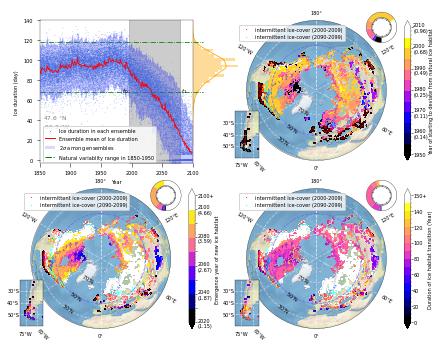

In [114]:
''' 
in order to get information about warming amplitude, we add the temperature anomaly relative to the climatological mean of 1850-1950 besides the years
the temperature anomaly is from 
df = pd.read_csv('.../trefht_glob_mean.csv')
df['Temp_anomaly'] = df.Temperature_glob_mean - df[df.year < 1950].Temperature_glob_mean.mean()
in which global mean is from TREFHT, which is 2 m temperature including on land and ocean.
'''
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (18 * cm ,14.4*cm))

line_span_hist_plot(mother_fig=fig, left=0.15, bottom=0.53, width=0.3, width_h=0.1,
                   height=0.35)
#ax = plt.gca()
#ax.text(0.1, 0.88, 'a', transform = fig.transFigure, fontsize = 6)
##
axs = fig.add_subplot(2,2,2, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('gnuplot2', 12)
#picolors = cmap(np.arange(15))
picolors = cmap(np.linspace(0,1,11))
pcolor_pie_plot(input_data=iceduration_sig_emerge, 
                mother_axs = axs,
               vmin = 1950,
               vmax = 2010,
               cmap = cmap,
                cmap_ninterv = 11,
                SH_adjust= [-0.22,0.02,0.02,0.03],
                pie_adjust=[0.2,0.3,0.1,0.1],
               picolors = picolors,
               cb_shrink=1,
                cb_aspect=20,
               cb_pad=0.1,
                cb_title_pad=0.8,
                hatch_label=True,
                cb_ticklabel = ['1950', '1960\n(0.14)', '1970\n(0.11)', '1980\n(0.25)', '1990\n(0.49)', '2000\n(0.68)', '2010\n(0.96)'],
                cb_label = 'Year of starting to deviate from natural ice habitat'
               )
ax.text(0.55, 0.88, 'b', transform = fig.transFigure, fontsize = 6)
##
axs = fig.add_subplot(2,2,3, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('gnuplot2', 9)
#picolors = cmap(np.arange(15))
picolors = cmap(np.linspace(0,1,8))
pcolor_pie_plot(input_data=iceduration_sig_termin, 
                mother_axs = axs,
               vmin = 2020,
               vmax = 2110,
               cmap = cmap,
                cmap_ninterv = 8,
                SH_adjust= [-0.22,0.02,0.02,0.03],
                pie_adjust=[0.2,0.3,0.1,0.1],
               picolors = picolors,
               cb_shrink=1,
                cb_aspect=20,
               cb_pad=0.1,
                hatch_label=True,
                cb_title_pad = 0.8,
                #cb_ticklabel= ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100', '2100+'],
                cb_ticklabel= ['2020\n(1.15)', '', '2040\n(1.87)', '', '2060\n(2.67)', '', '2080\n(3.59)', '', '2100\n(4.66)', '2100+'],
                cb_label = 'Emergence year of new ice habitat'
               )
ax.text(0.1, 0.5, 'c', transform = fig.transFigure, fontsize = 6)
##
axs = fig.add_subplot(2,2,4, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('gnuplot2', 16)
#picolors = cmap(np.arange(15))
picolors = cmap(np.linspace(0,1,15))
pcolor_pie_plot(input_data=iceduration_adap_window, 
                mother_axs = axs,
               vmin = 0,
               vmax = 160,
               cmap = cmap,
                cmap_ninterv = 15,
                SH_adjust= [-0.22,0.02,0.02,0.03],
                pie_adjust=[0.2,0.3,0.1,0.1],
               picolors = picolors,
               cb_shrink=1,
                cb_aspect=20,
               cb_pad=0.1,
                hatch_label=True,
                cb_title_pad = 0.8,
                cb_ticklabel = ['0', '20', '40', '60', '80', '100', '120', '140','150+'],
                cb_label = 'Duration of ice habitat transition (Year)'
               )
ax.text(0.55, 0.5, 'd', transform = fig.transFigure, fontsize = 6)
#
plt.savefig('.../LAKE_ICE/Fig_5.pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)
plt.close(fig)